# **Analyzing Crime Patterns in Chicago** *by Ahmed Hmila*



This project was conducted as part of a Big Data course at university.The required minimum size was 2GB of data hence the meme below 🤠 . The aim of the project is to analyze and visualize crime patterns in Chicago using the Chicago Crimes Dataset from 2001 to the present. The analysis focuses on identifying temporal patterns and crime hotspots to provide insights that could aid in crime prevention strategies.

# Dataset Description

## Dataset Chicago Crimes Dataset (2001 - Present)

### ***Overview***

The Chicago Crimes Dataset contains records of reported crime incidents in the City of Chicago from 2001 to the present, excluding the most recent seven days. The data is sourced from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. Each row represents a reported crime.

**Note:** To protect victim privacy, specific addresses are not provided; locations are shown at the block level.

### Dataset Summary

- **Total Rows:** Approximately 8.21 million
- **Total Columns:** 22
- **Each Row Represents:** A reported crime incident

### Column Descriptions

| Column                | Description                                                                                                                  | Data Type     |
|-----------------------|------------------------------------------------------------------------------------------------------------------------------|---------------|
| **ID**                | Unique identifier for each record.                                                                                           | Number        |
| **Case Number**       | Chicago Police Department Records Division (RD) Number, unique to each incident.                                             | Text          |
| **Date**              | Date and time when the incident occurred (sometimes estimated).                                                              | Timestamp     |
| **Block**             | Partially redacted address where the incident occurred, displayed at the block level.                                        | Text          |
| **IUCR**              | Illinois Uniform Crime Reporting code linked to the primary type and description.                                            | Text          |
| **Primary Type**      | Primary crime classification description.                                                                                    | Text          |
| **Description**       | Secondary crime classification (subcategory of the primary type).                                                            | Text          |
| **Location Description** | Description of the type of location where the incident occurred.                                                          | Text          |
| **Arrest**            | Indicates whether an arrest was made (**True** or **False**).                                                                | Boolean       |
| **Domestic**          | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.                        | Boolean       |
| **Beat**              | Police beat where the incident occurred (smallest police geographic area).                                                   | Text          |
| **District**          | Police district where the incident occurred.                                                                                 | Text          |
| **Ward**              | City Council district (ward) where the incident occurred.                                                                    | Number        |
| **Community Area**    | Community area number where the incident occurred (Chicago has 77 community areas).                                          | Text          |
| **FBI Code**          | Crime classification code as outlined in the FBI's National Incident-Based Reporting System (NIBRS).                         | Text          |
| **X Coordinate**      | X coordinate of the location in State Plane Illinois East NAD 1983 projection (shifted for privacy).                         | Number        |
| **Y Coordinate**      | Y coordinate of the location in State Plane Illinois East NAD 1983 projection (shifted for privacy).                         | Number        |
| **Year**              | Year when the incident occurred.                                                                                             | Number        |
| **Updated On**        | Date and time when the record was last updated.                                                                              | Timestamp     |
| **Latitude**          | Latitude of the location where the incident occurred (shifted for privacy).                                                  | Number        |
| **Longitude**         | Longitude of the location where the incident occurred (shifted for privacy).                                                 | Number        |
| **Location**          | Combined latitude and longitude in a format suitable for mapping and geographic operations (shifted for privacy).            | Geolocation   |

### Additional Information

- **Data Source:** [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2)
- **Data Updated:** Daily
- **Privacy Notice:** Addresses are shown at the block level to protect the privacy of crime victims.

For a list of Illinois Uniform Crime Reporting (IUCR) codes, visit the [Chicago Police Department IUCR Codes](https://data.cityofchicago.org/Public-Safety/Chicago-Police-Department-Illinois-Uniform-Crime-R/c7ck-438e).

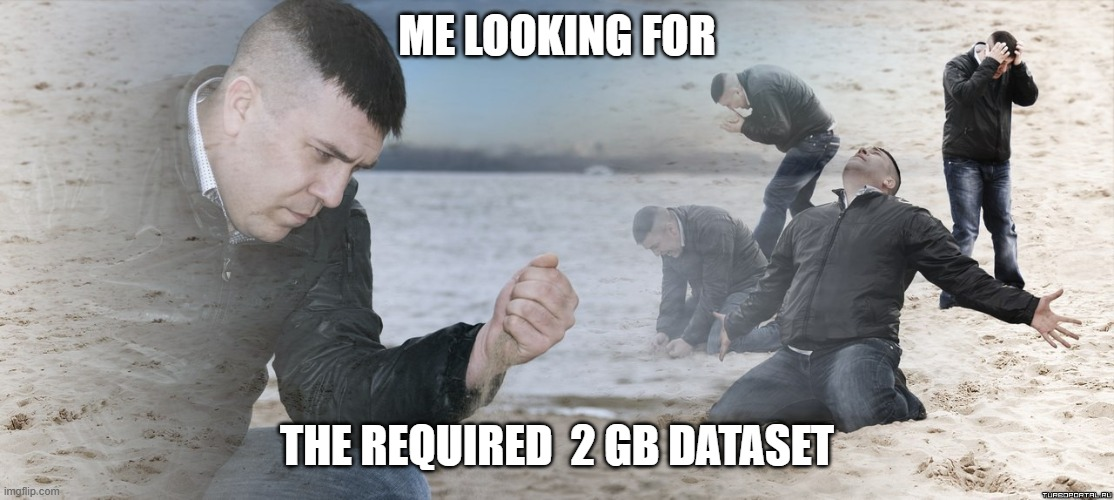

# Installing PySpark

In [ ]:
!pip install pyspark

# Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

### Visualization Libs


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### Visualization Params


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Spark Params

Starting SparkSession

In [ ]:
spark = SparkSession.builder.appName("Very-beeeg-data").getOrCreate()

In [ ]:
spark

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Very-beeeg-data>

Define the schema

In [ ]:
schema = StructType([
    StructField('ID', IntegerType(), True),
    StructField('Case Number', StringType(), True),
    StructField('Date', StringType(), True),
    StructField('Block', StringType(), True),
    StructField('IUCR', StringType(), True),
    StructField('Primary Type', StringType(), True),
    StructField('Description', StringType(), True),
    StructField('Location Description', StringType(), True),
    StructField('Arrest', BooleanType(), True),
    StructField('Domestic', BooleanType(), True),
    StructField('Beat', IntegerType(), True),
    StructField('District', DoubleType(), True),
    StructField('Ward', DoubleType(), True),
    StructField('Community Area', DoubleType(), True),
    StructField('FBI Code', StringType(), True),
    StructField('X Coordinate', DoubleType(), True),
    StructField('Y Coordinate', DoubleType(), True),
    StructField('Year', IntegerType(), True),
    StructField('Updated On', StringType(), True),
    StructField('Latitude', DoubleType(), True),
    StructField('Longitude', DoubleType(), True),
    StructField('Location', StringType(), True)
])

## Loading Data

In [ ]:
folder_path ='your/folder/path/that/contains/the_dataset'
df = spark.read \
    .option("header", "true") \
    .schema(schema) \
   .csv(folder_path)

In [ ]:
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()


+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|               13783|     0|       0|   0|      47|614830|        613456|       0|       90238|       90238|   0|         0|   90238|    90238|   90238|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

# Data Preprocessing


### Dropping Nulls

In [ ]:
df_clean = df.dropna(subset=["Latitude", "Longitude", "Primary Type","ID"])

### Rechecking null values

In [ ]:
cnull_counts = df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in df_clean.columns])
cnull_counts.show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                8868|     0|       0|   0|      47|605577|        604254|       0|           0|           0|   0|         0|       0|        0|       0|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

### Convert data types


In [ ]:
df_clean = df_clean.withColumn("Arrest", col("Arrest").cast("boolean"))
df_clean = df_clean.withColumn("Domestic", col("Domestic").cast("boolean"))

### Convert Date column to timestamp

In [ ]:
df_clean = df_clean.withColumn("Date", to_timestamp(col("Date"), "MM/dd/yyyy hh:mm:ss a"))

###  Extract additional time features

In [ ]:
df_clean = df_clean.withColumn("Month", month("Date"))
df_clean = df_clean.withColumn("Day", dayofmonth("Date"))
df_clean = df_clean.withColumn("Hour", hour("Date"))

### Checking Schema

In [ ]:
df_clean.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nulla

In [ ]:
df_clean.dtypes

[('ID', 'int'),
 ('Case Number', 'string'),
 ('Date', 'timestamp'),
 ('Block', 'string'),
 ('IUCR', 'string'),
 ('Primary Type', 'string'),
 ('Description', 'string'),
 ('Location Description', 'string'),
 ('Arrest', 'boolean'),
 ('Domestic', 'boolean'),
 ('Beat', 'int'),
 ('District', 'double'),
 ('Ward', 'double'),
 ('Community Area', 'double'),
 ('FBI Code', 'string'),
 ('X Coordinate', 'double'),
 ('Y Coordinate', 'double'),
 ('Year', 'int'),
 ('Updated On', 'string'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Location', 'string'),
 ('Month', 'int'),
 ('Day', 'int'),
 ('Hour', 'int')]

In [ ]:
num_rows = df_clean.count()

num_cols = len(df_clean.columns)

print(f"Shape: ({num_rows}, {num_cols})")

Shape: (8118833, 25)


## Count crimes by Primary Type

In [ ]:
crime_counts = df_clean.groupBy("Primary Type").count().orderBy(desc("count"))
crime_counts.show()

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1717517|
|             BATTERY|1490300|
|     CRIMINAL DAMAGE| 930141|
|           NARCOTICS| 744134|
|             ASSAULT| 542783|
|       OTHER OFFENSE| 505613|
|            BURGLARY| 435312|
| MOTOR VEHICLE THEFT| 412154|
|  DECEPTIVE PRACTICE| 352644|
|             ROBBERY| 307425|
|   CRIMINAL TRESPASS| 220935|
|   WEAPONS VIOLATION| 119210|
|        PROSTITUTION|  69564|
|OFFENSE INVOLVING...|  54617|
|PUBLIC PEACE VIOL...|  53603|
|         SEX OFFENSE|  30962|
| CRIM SEXUAL ASSAULT|  25952|
|INTERFERENCE WITH...|  19347|
|LIQUOR LAW VIOLATION|  15068|
|            GAMBLING|  14553|
+--------------------+-------+
only showing top 20 rows



In [ ]:
arrest_rates = df_clean.groupBy("Primary Type") \
    .agg(avg(col("Arrest").cast("integer")).alias("Arrest Rate")) \
    .orderBy(desc("Arrest Rate"))
arrest_rates.show()

+--------------------+-------------------+
|        Primary Type|        Arrest Rate|
+--------------------+-------------------+
|   DOMESTIC VIOLENCE|                1.0|
|        PROSTITUTION| 0.9958024265424645|
|           NARCOTICS| 0.9938613206761148|
|            GAMBLING| 0.9934034219748505|
|LIQUOR LAW VIOLATION| 0.9911733474913724|
|    PUBLIC INDECENCY| 0.9807692307692307|
|CONCEALED CARRY L...|              0.965|
|INTERFERENCE WITH...| 0.9180751537706104|
|           OBSCENITY|  0.763807285546416|
|   WEAPONS VIOLATION| 0.7247546346782988|
|   CRIMINAL TRESPASS| 0.6869622287098015|
|OTHER NARCOTIC VI...| 0.6821192052980133|
|PUBLIC PEACE VIOL...| 0.6273156353189188|
|            HOMICIDE| 0.4741461975363281|
|NON-CRIMINAL (SUB...| 0.3333333333333333|
|         SEX OFFENSE|0.26603578580195075|
|             BATTERY| 0.2173112796081326|
|             ASSAULT|0.20506906074803374|
|OFFENSE INVOLVING...|0.19389567350824835|
|       OTHER OFFENSE|0.17634831382895613|
+----------

In [ ]:
windowed_counts = df_clean.groupBy(
    window("Date", "1 hour"),
    "Primary Type"
).count().orderBy("window")
windowed_counts.show()

+--------------------+--------------------+-----+
|              window|        Primary Type|count|
+--------------------+--------------------+-----+
|{2001-01-01 00:00...|  DECEPTIVE PRACTICE|   28|
|{2001-01-01 00:00...| CRIM SEXUAL ASSAULT|   18|
|{2001-01-01 00:00...|OFFENSE INVOLVING...|   58|
|{2001-01-01 00:00...|         SEX OFFENSE|   16|
|{2001-01-01 00:00...|       OTHER OFFENSE|   15|
|{2001-01-01 00:00...|               THEFT|  119|
|{2001-01-01 00:00...|   CRIMINAL TRESPASS|    4|
|{2001-01-01 00:00...|            BURGLARY|    1|
|{2001-01-01 00:00...|             BATTERY|   18|
|{2001-01-01 00:00...|           NARCOTICS|    3|
|{2001-01-01 00:00...|   WEAPONS VIOLATION|   14|
|{2001-01-01 00:00...|             ASSAULT|    4|
|{2001-01-01 00:00...|     CRIMINAL DAMAGE|   49|
|{2001-01-01 00:00...| MOTOR VEHICLE THEFT|    9|
|{2001-01-01 00:00...|             ROBBERY|    2|
|{2001-01-01 01:00...|               THEFT|    9|
|{2001-01-01 01:00...|            BURGLARY|    1|


# **Hypotheses**

### **Hypothesis 1:** Certain crime types have higher arrest rates than others.

Analysis: By calculating the average arrest rate per crime type, we can identify which crimes are more likely to result in an arrest.
Expectation: Violent crimes such as homicide or assault may have higher arrest rates compared to property crimes.

### **Hypothesis 2:** Crime occurrences vary by time of day.

Analysis: Using windowed counts and extracting the hour and day information, we can analyze crime patterns over time.
Expectation: Crimes may be more frequent during nighttime hours or weekends.


### **Hypothesis 3:** Crime Rates Vary by Month and Season

- **Analysis:** Investigate whether certain months or seasons have higher crime rates.
- **Expectation:** Crimes might increase during summer months due to warmer weather and increased outdoor activities.

### **Hypothesis 4:** Certain Locations Have Higher Incidents of Specific Crime Types

- **Analysis:** Identify hotspots for specific crime types by analyzing crime frequency by location description.
- **Expectation:** For example, thefts might be more common in commercial areas, while burglaries are more frequent in residential areas.

### **Hypothesis 5:** Domestic Crimes Have Different Patterns Compared to Non-Domestic Crimes

- **Analysis:** Compare the characteristics of domestic crimes versus non-domestic crimes, such as times, locations, and arrest rates.
- **Expectation:** Domestic crimes may have higher occurrence during evenings and in residential areas.


# Visualization

<Figure size 1200x1200 with 0 Axes>

([<matplotlib.patches.Wedge at 0x7a84335c28c0>,
 [Text(-0.6784147225198366, 0.8658830546143823, 'THEFT'),
  Text(-1.0388268064559734, -0.3617165550378965, 'BATTERY'),
  Text(-0.3241639478278648, -1.0511506718490236, 'CRIMINAL DAMAGE'),
  Text(0.375871897690854, -1.0337892998702765, 'NARCOTICS'),
  Text(0.8240090654673792, -0.7287036846534924, 'ASSAULT'),
  Text(1.0447054043037718, -0.3443698857601997, 'OTHER OFFENSE'),
  Text(1.0988527807837727, 0.05022515469135378, 'BURGLARY'),
  Text(1.0241201736627232, 0.40146963757802845, 'MOTOR VEHICLE THEFT'),
  Text(0.862516113126163, 0.6826902332666961, 'DECEPTIVE PRACTICE'),
  Text(0.662055618355857, 0.8784545282502925, 'ROBBERY'),
  Text(0.46991584512408535, 0.994574833032345, 'CRIMINAL TRESPASS'),
  Text(0.33532353026051054, 1.0476440855813718, 'WEAPONS VIOLATION'),
  Text(0.2579707965601637, 1.0693227146760302, 'PROSTITUTION'),
  Text(0.2063097110807067, 1.0804796634429523, 'OFFENSE INVOLVING CHILDREN'),
  Text(0.16089604883821113, 1.088169

Text(0.5, 1.0, 'Distribution of Crime Types')

(-1.099995605481169,
 1.0999997892933355,
 -1.0999999506664435,
 1.099999997650783)

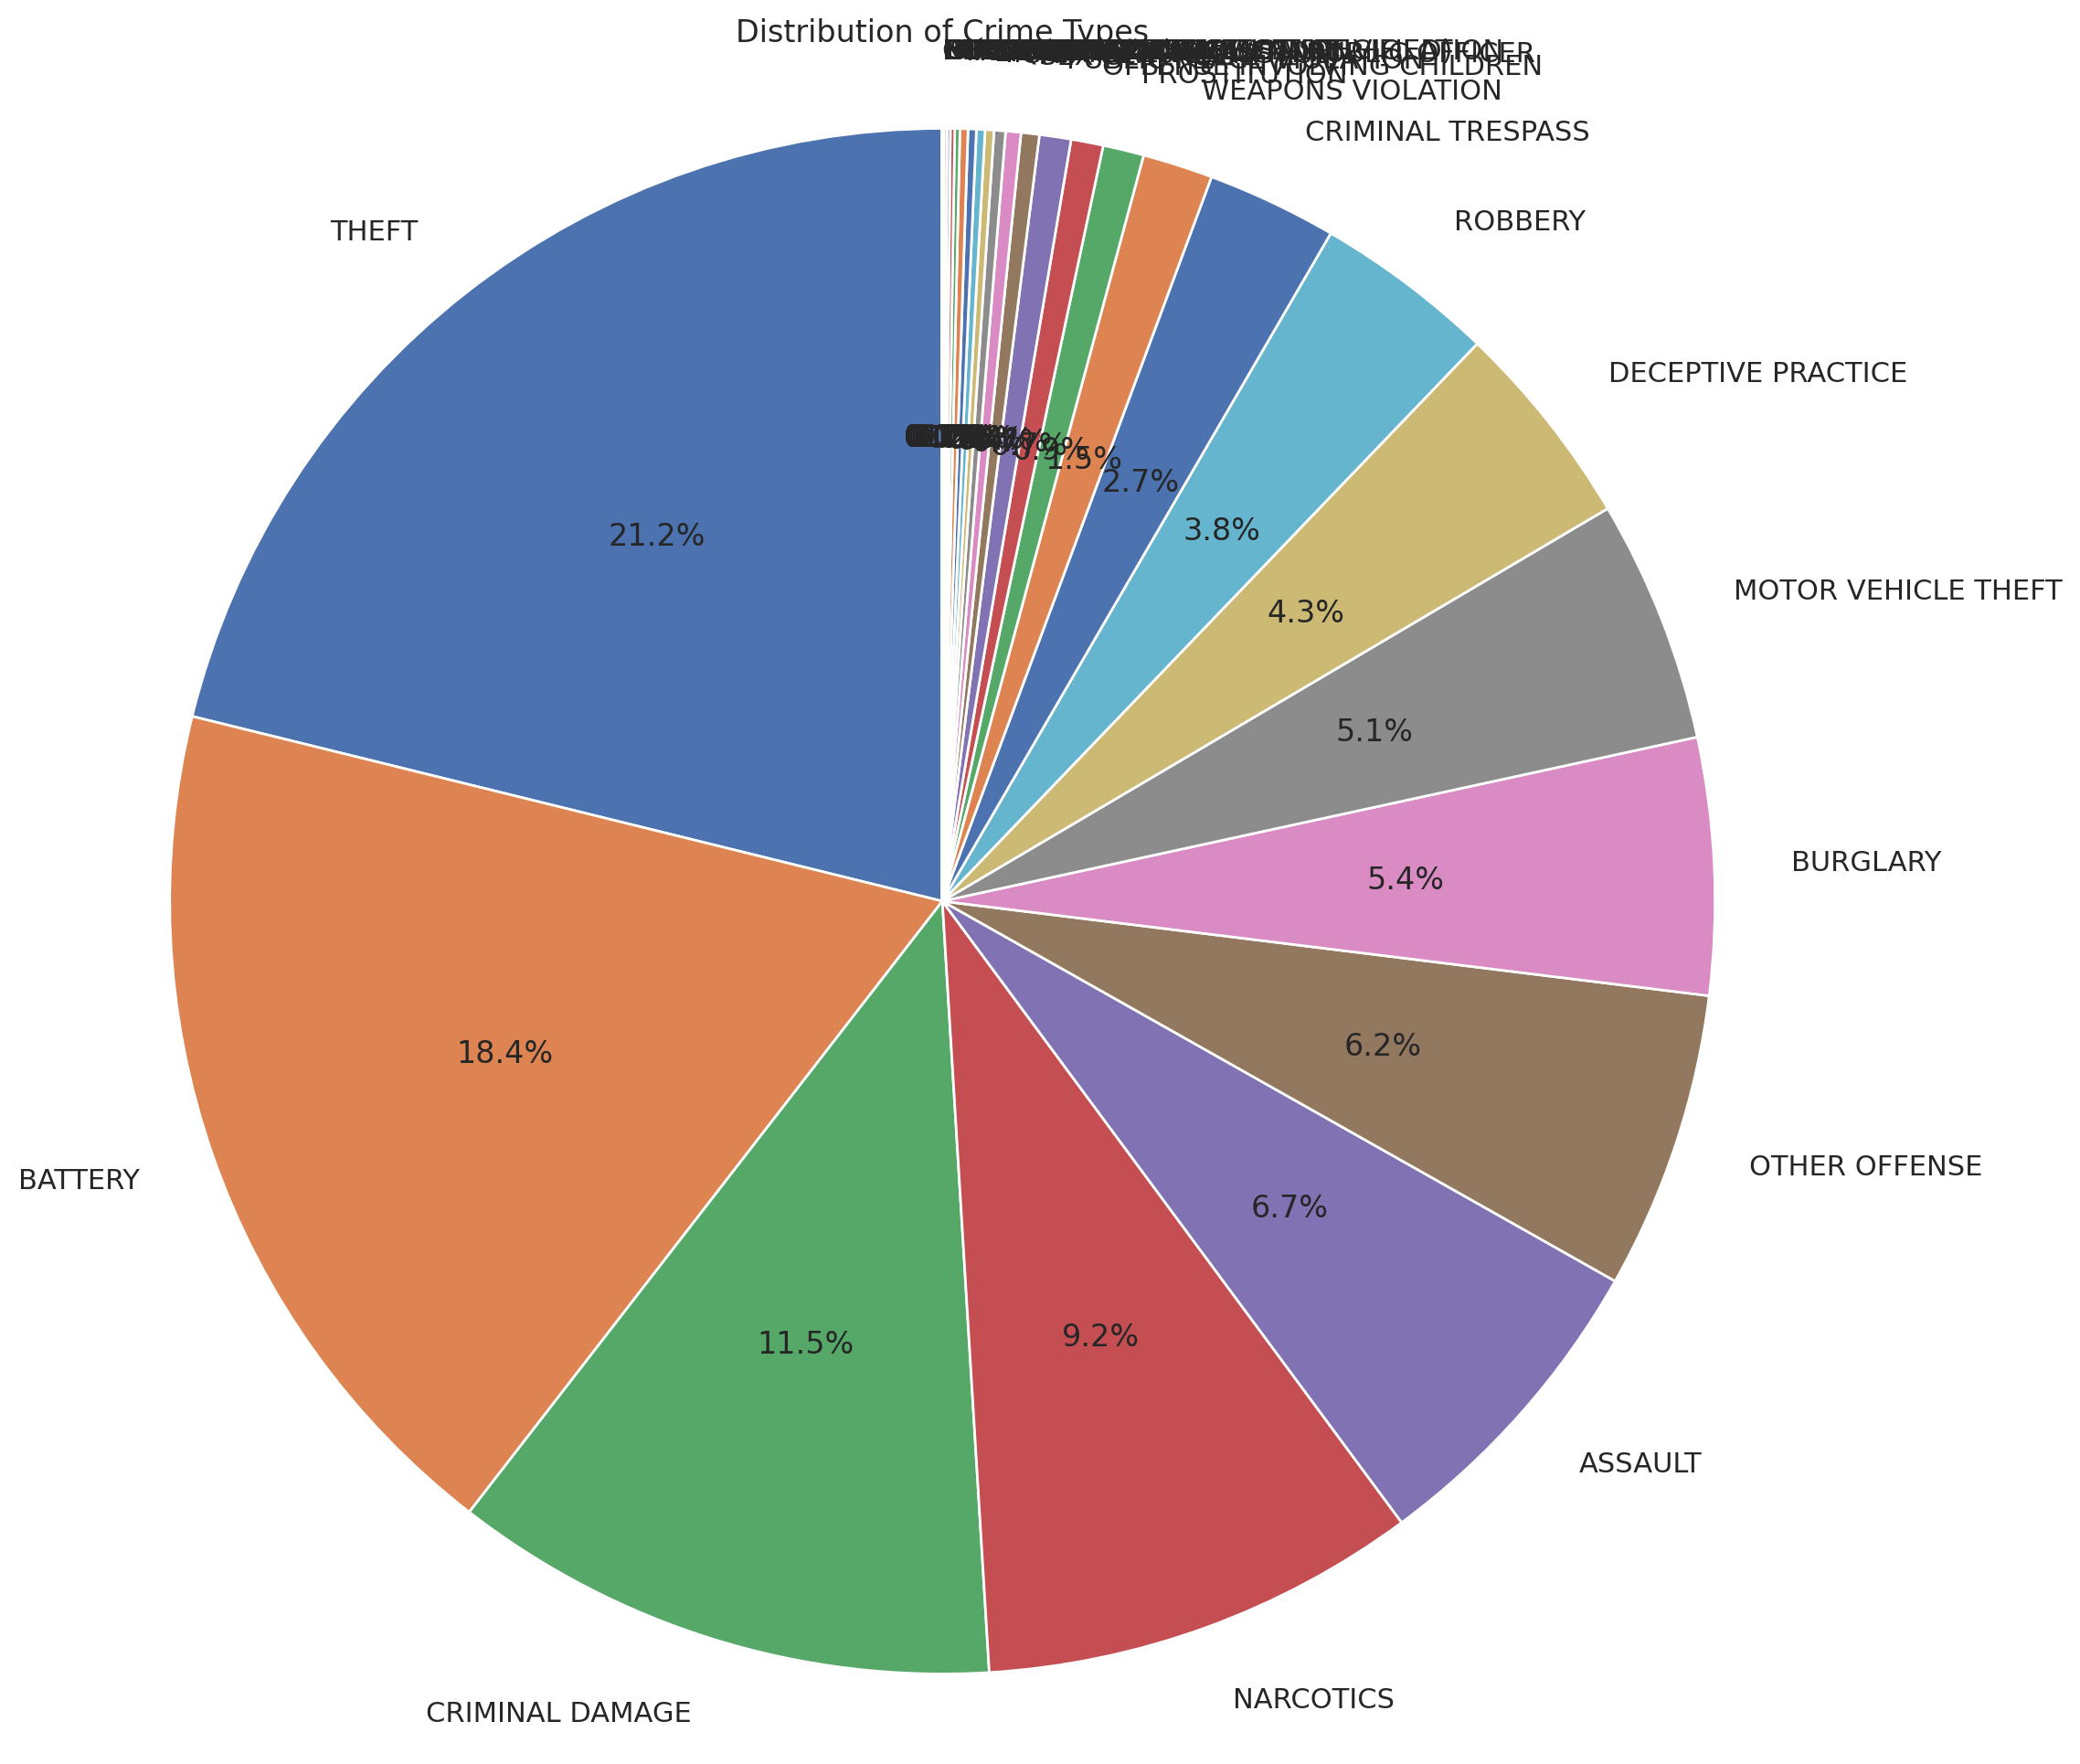

In [ ]:
crime_by_type_pdPlot = crime_counts.toPandas()

plt.figure(figsize=(12, 12))
plt.pie(crime_by_type_pdPlot['count'], labels=crime_by_type_pdPlot['Primary Type'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Crime Types')
plt.axis('equal')
plt.show()

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 2 artists>

Text(0.5, 0, 'Arrest (True/False)')

Text(0, 0.5, 'Number of Crimes')

Text(0.5, 1.0, 'Number of Crimes vs. Arrests')

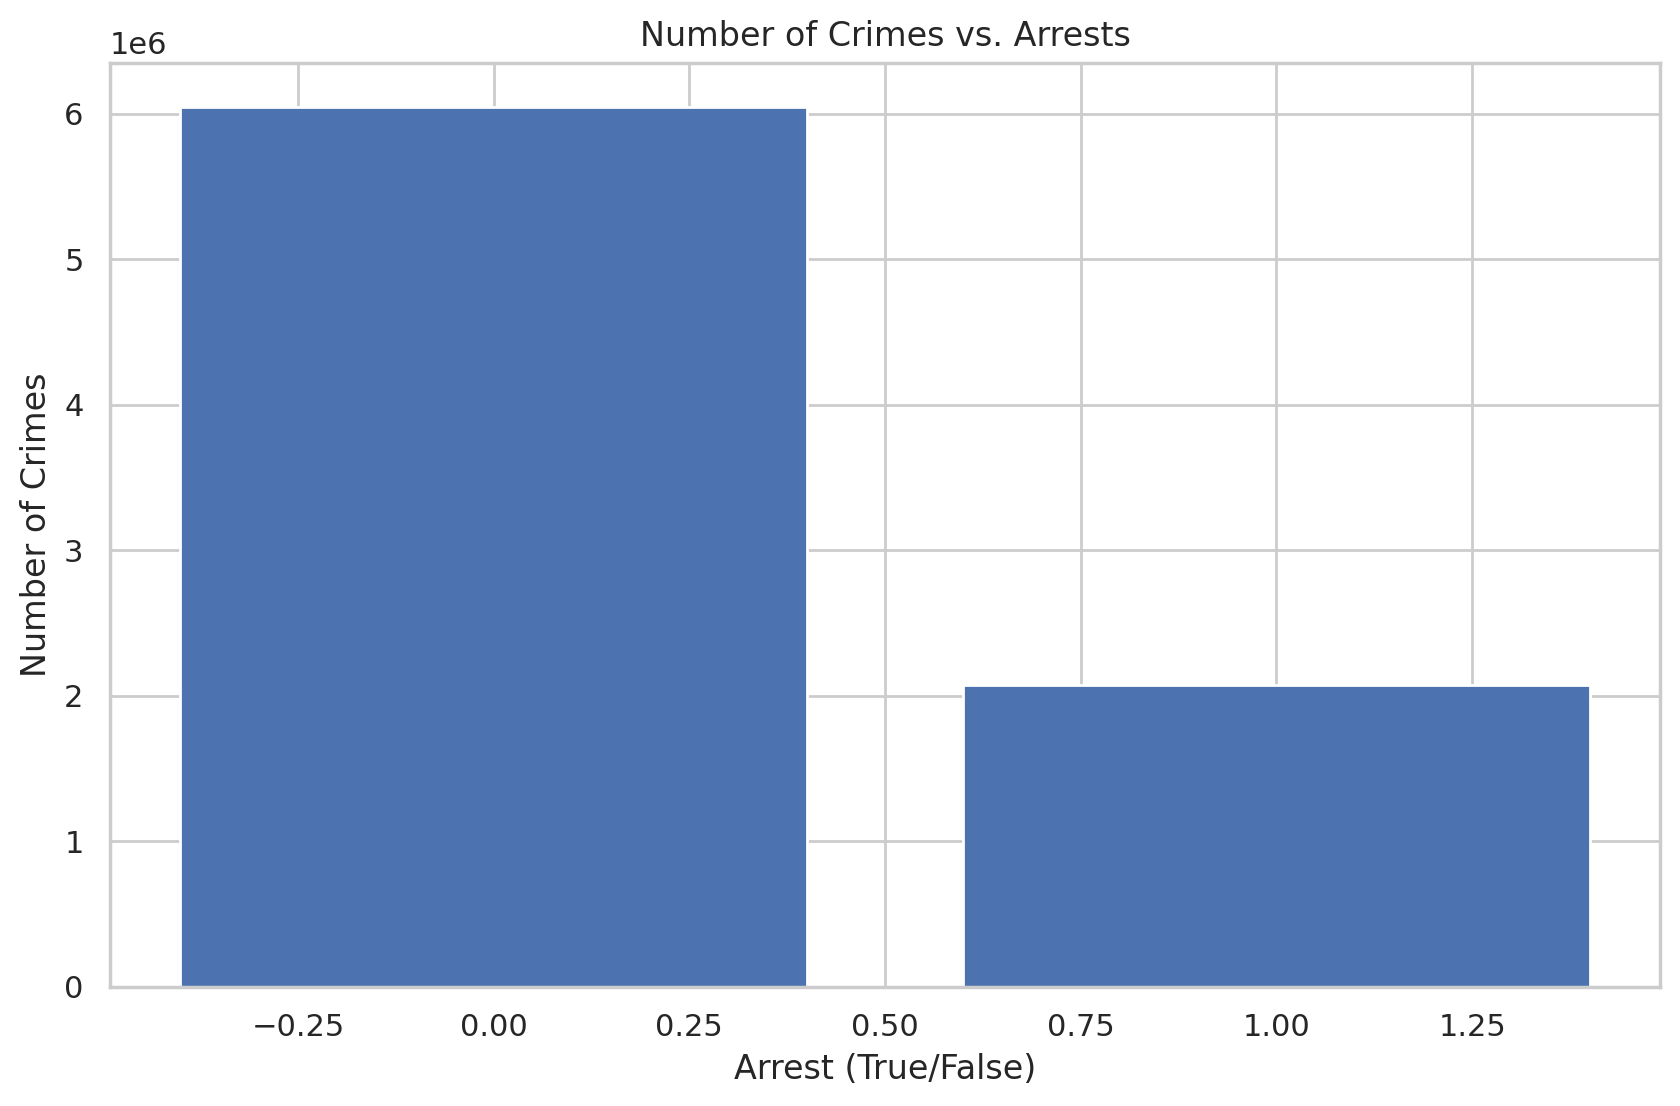

In [ ]:
crimes_by_arrest = df_clean.groupBy("Arrest").count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(crimes_by_arrest["Arrest"], crimes_by_arrest["count"])
plt.xlabel("Arrest (True/False)")
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes vs. Arrests")
plt.show()


### **Hypothesis 2:** Crime occurrences vary by time of day.



In [ ]:
crime_by_hour = df_clean.groupBy("Hour").count().orderBy("Hour")

hour_counts = crime_by_hour.toPandas()

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Hour', ylabel='count'>

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Number of Crimes')

Text(0.5, 1.0, 'Crime Count by Hour of the Day')

([<matplotlib.axis.XTick at 0x7a84303a1120>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

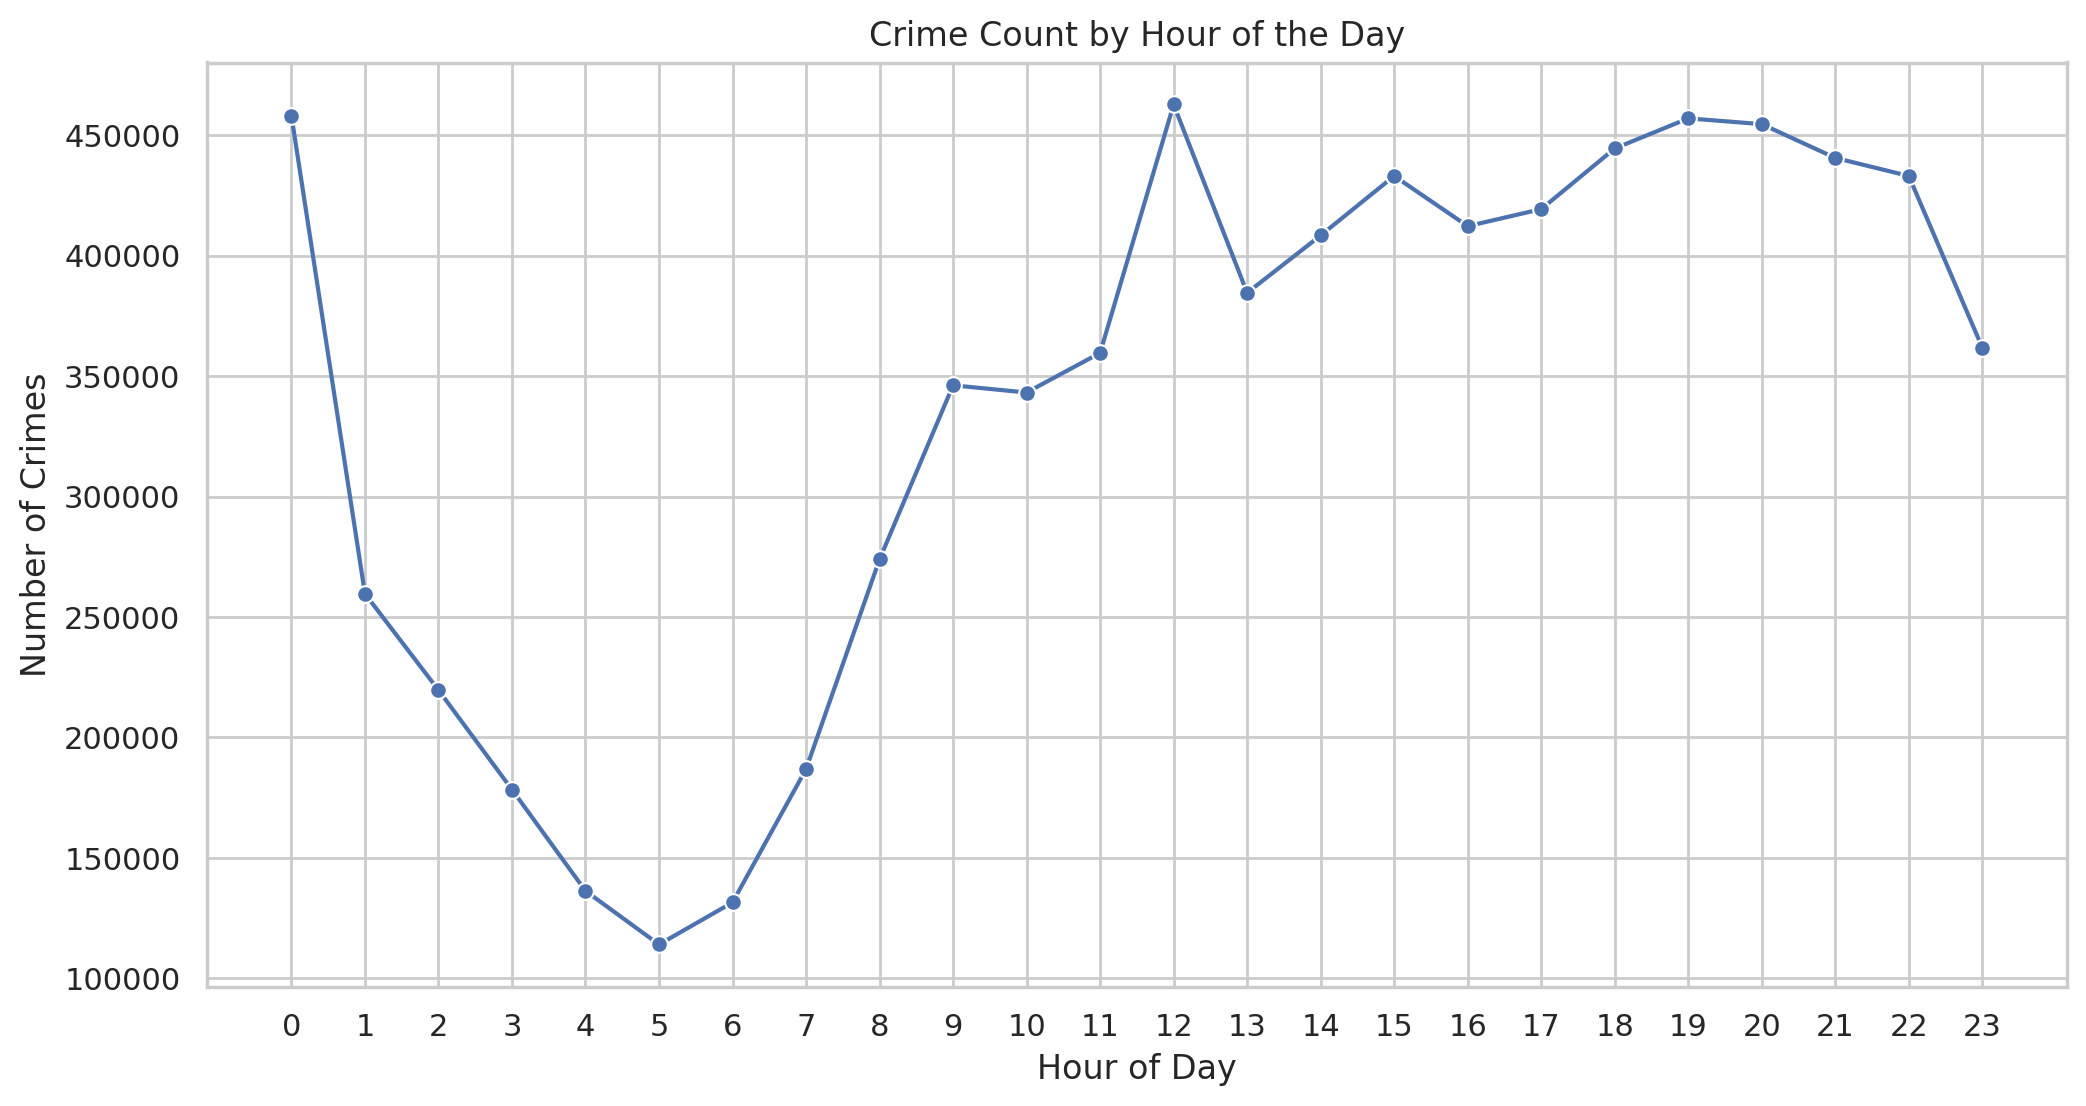

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='count', data=hour_counts, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.title('Crime Count by Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## Hypothesis 3: Crime Rates Vary by Month and Season


In [ ]:
crime_by_month = df_clean.groupBy("Month") \
    .count() \
    .orderBy("Month")

month_counts = crime_by_month.toPandas()

<Figure size 1000x600 with 0 Axes>

<ipython-input-38-8bda6537ef77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='count', data=month_counts, palette='viridis')


<Axes: xlabel='Month', ylabel='count'>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Number of Crimes')

Text(0.5, 1.0, 'Crime Count by Month')

([<matplotlib.axis.XTick at 0x7a8430dc5d80>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sep'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

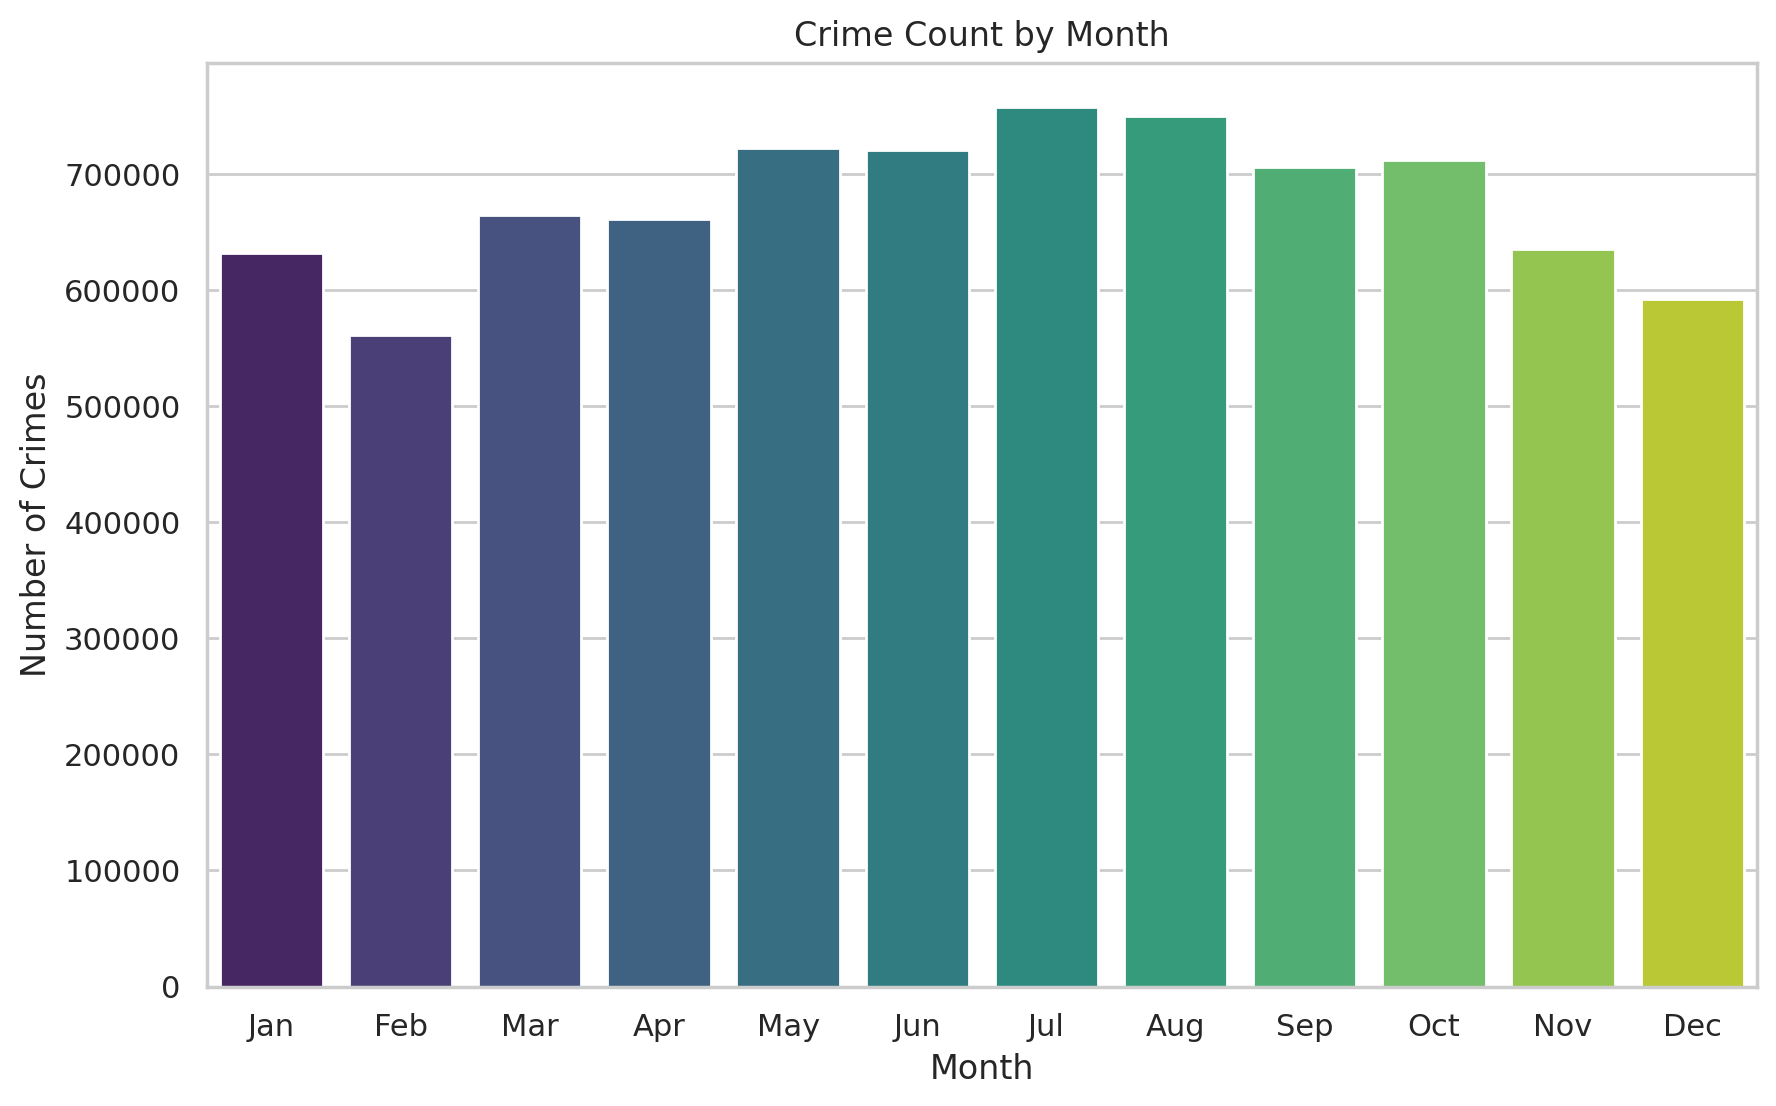

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='count', data=month_counts, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Crime Count by Month')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Hypothesis 4: Specific Crime Types are Concentrated in Certain Locations


In [ ]:
top_locations = df_clean.groupBy("Location Description") \
    .count() \
    .orderBy(desc("count")) \
    .limit(10)

top_location_list = [row['Location Description'] for row in top_locations.collect()]
filtered_df = df_clean.where(col("Location Description").isin(top_location_list))

crime_by_location = filtered_df.groupBy("Location Description", "Primary Type") \
    .count()

crime_location_pd = crime_by_location.toPandas()

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Primary Type', ylabel='Location Description'>

Text(0.5, 1.0, 'Crime Types by Top Location Descriptions')

Text(0.5, 54.249999999999986, 'Crime Type')

Text(116.24999999999997, 0.5, 'Location Description')

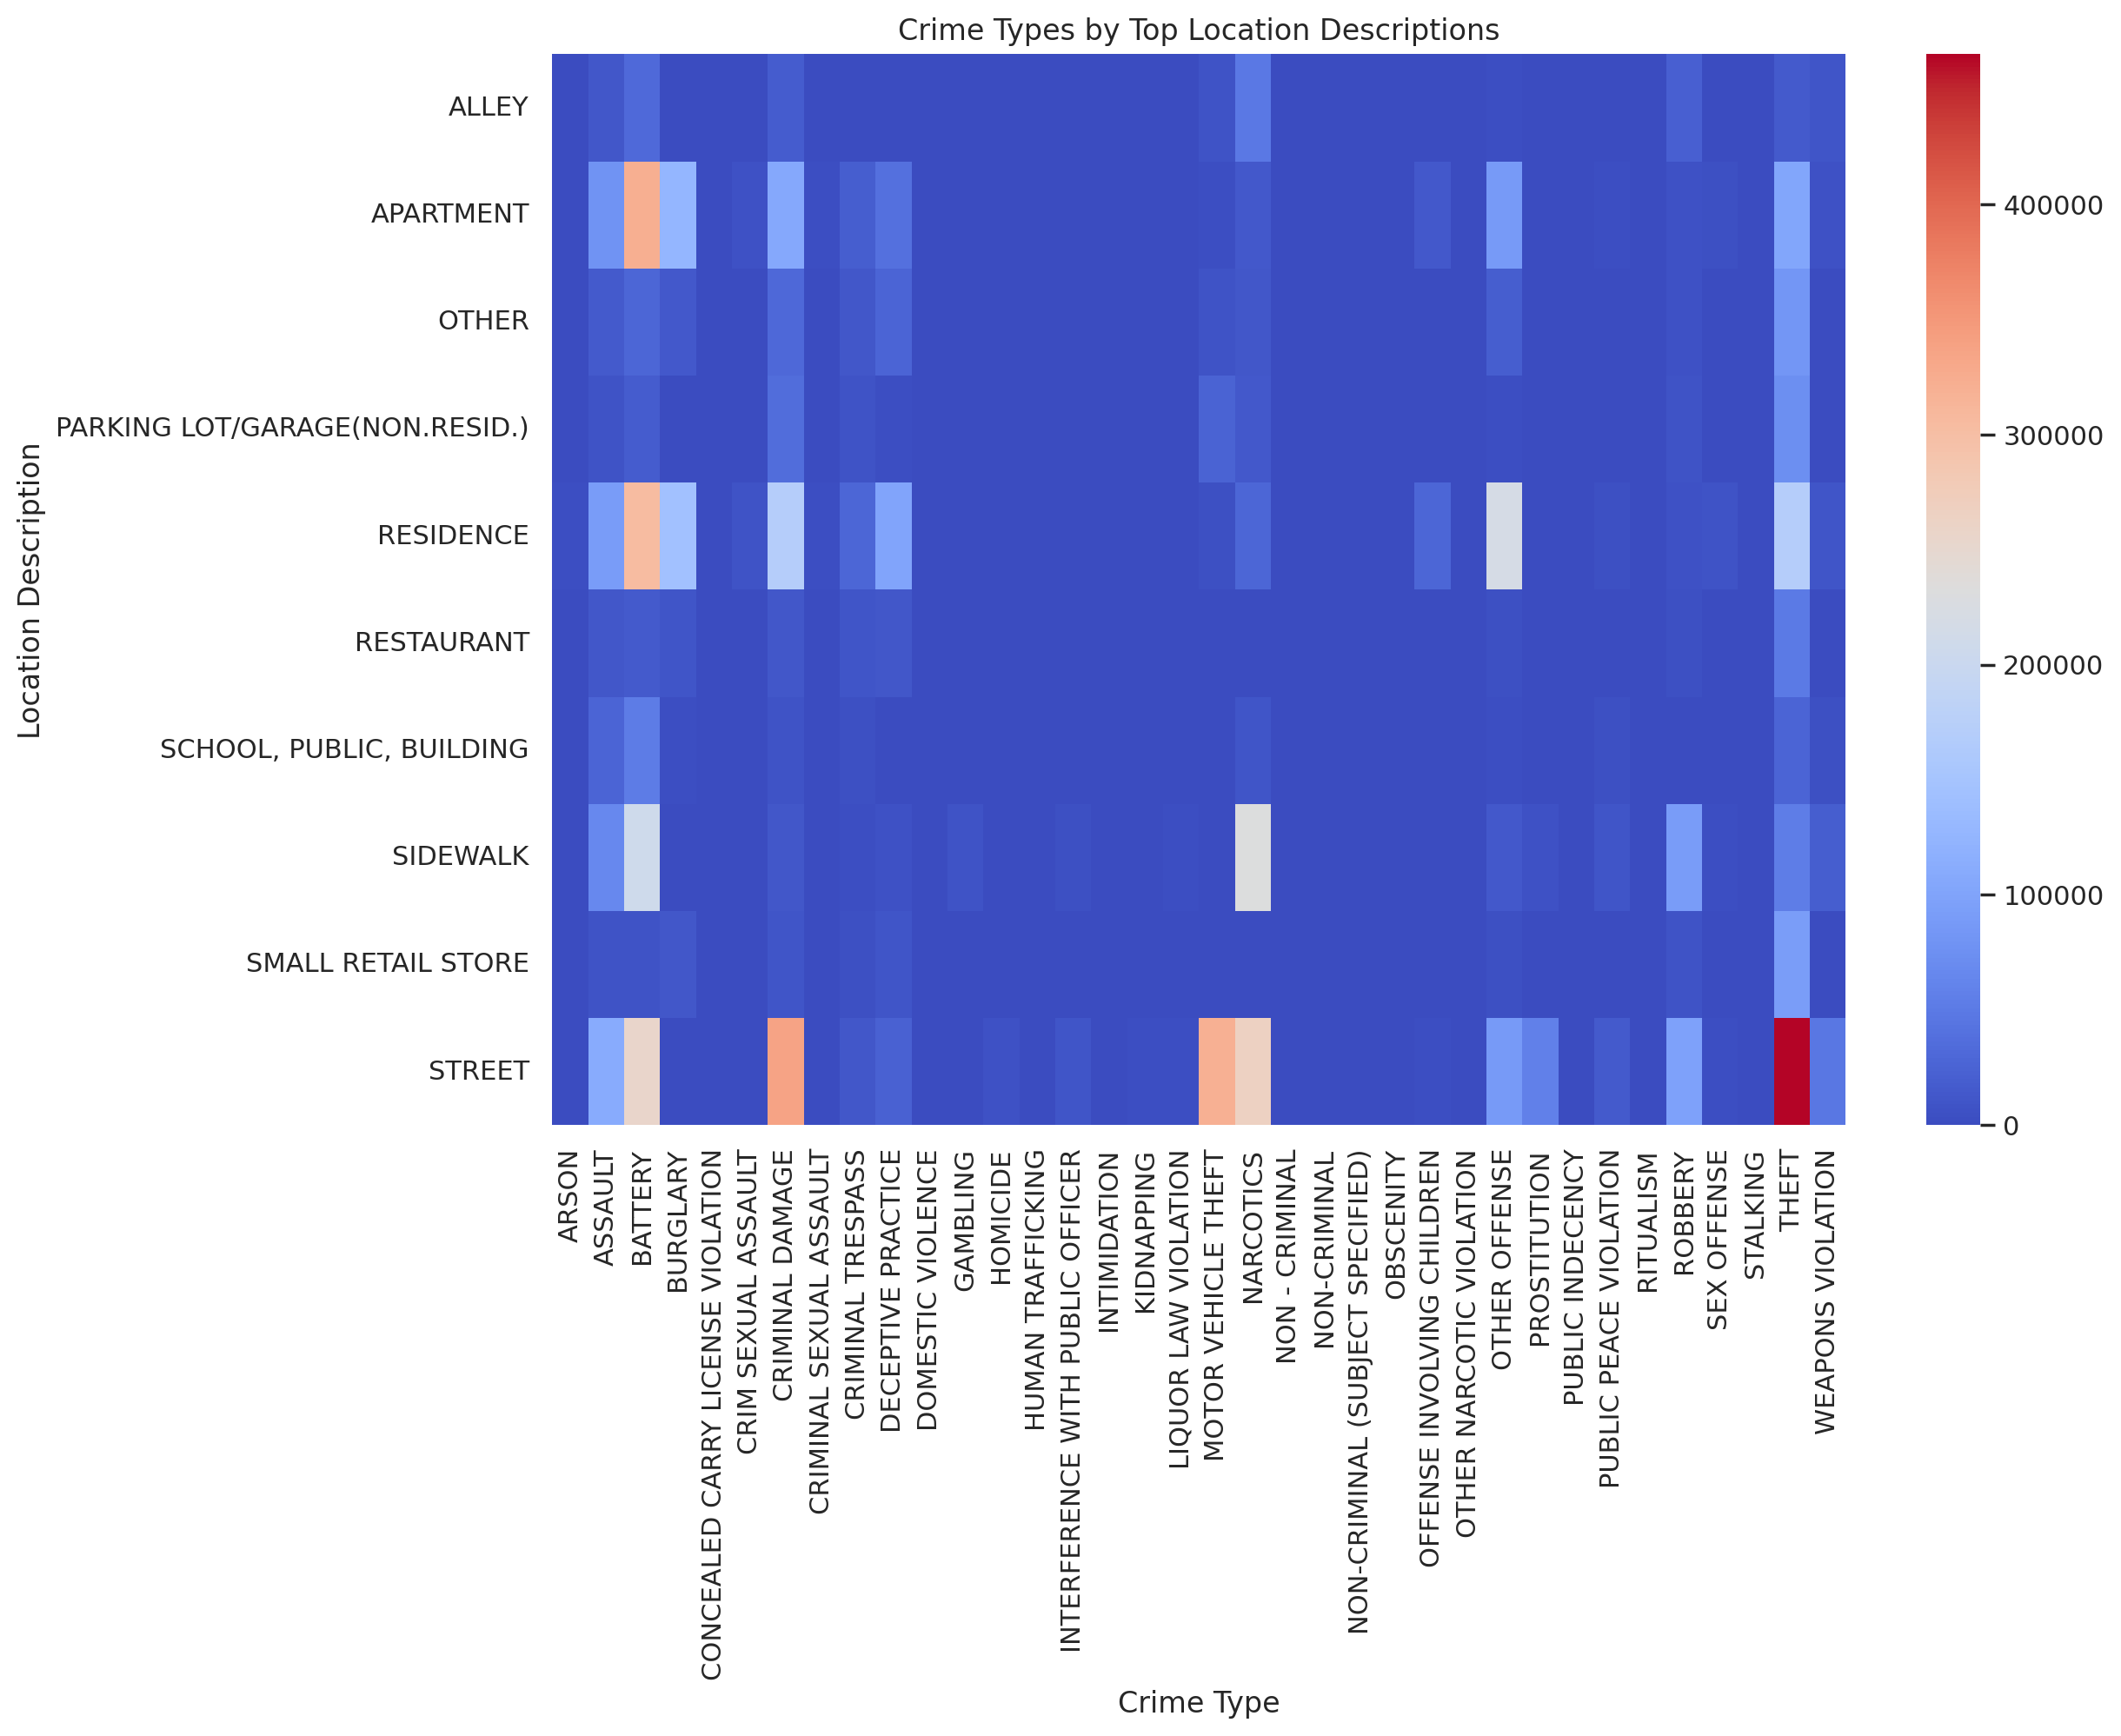

In [ ]:
plt.figure(figsize=(12, 8))
pivot_table = crime_location_pd.pivot(index='Location Description',
                                     columns='Primary Type',
                                     values='count').fillna(0)
sns.heatmap(pivot_table, annot=False, cmap='coolwarm')
plt.title('Crime Types by Top Location Descriptions')
plt.xlabel('Crime Type')
plt.ylabel('Location Description')
plt.show()

In [ ]:
top_locations = df_clean.groupBy("Location Description") \
    .count() \
    .orderBy(desc("count")) \
    .limit(10)

top_location_list = [row['Location Description'] for row in top_locations.collect()]

In [ ]:
top_primary_types = df_clean.groupBy("Primary Type") \
    .count() \
    .orderBy(desc("count")) \
    .limit(5)

top_primary_type_list = [row['Primary Type'] for row in top_primary_types.collect()]

In [ ]:
filtered_df = df_clean.filter(
    (col("Location Description").isin(top_location_list)) &
    (col("Primary Type").isin(top_primary_type_list))
)

In [ ]:
crime_by_location = filtered_df.groupBy("Location Description", "Primary Type") \
    .count()
crime_location_pd = crime_by_location.toPandas()

Text(0.5, 1.0, 'Top Crime Types by Top Locations')

Text(0.5, 0, 'Location Description')

Text(0, 0.5, 'Number of Crimes')

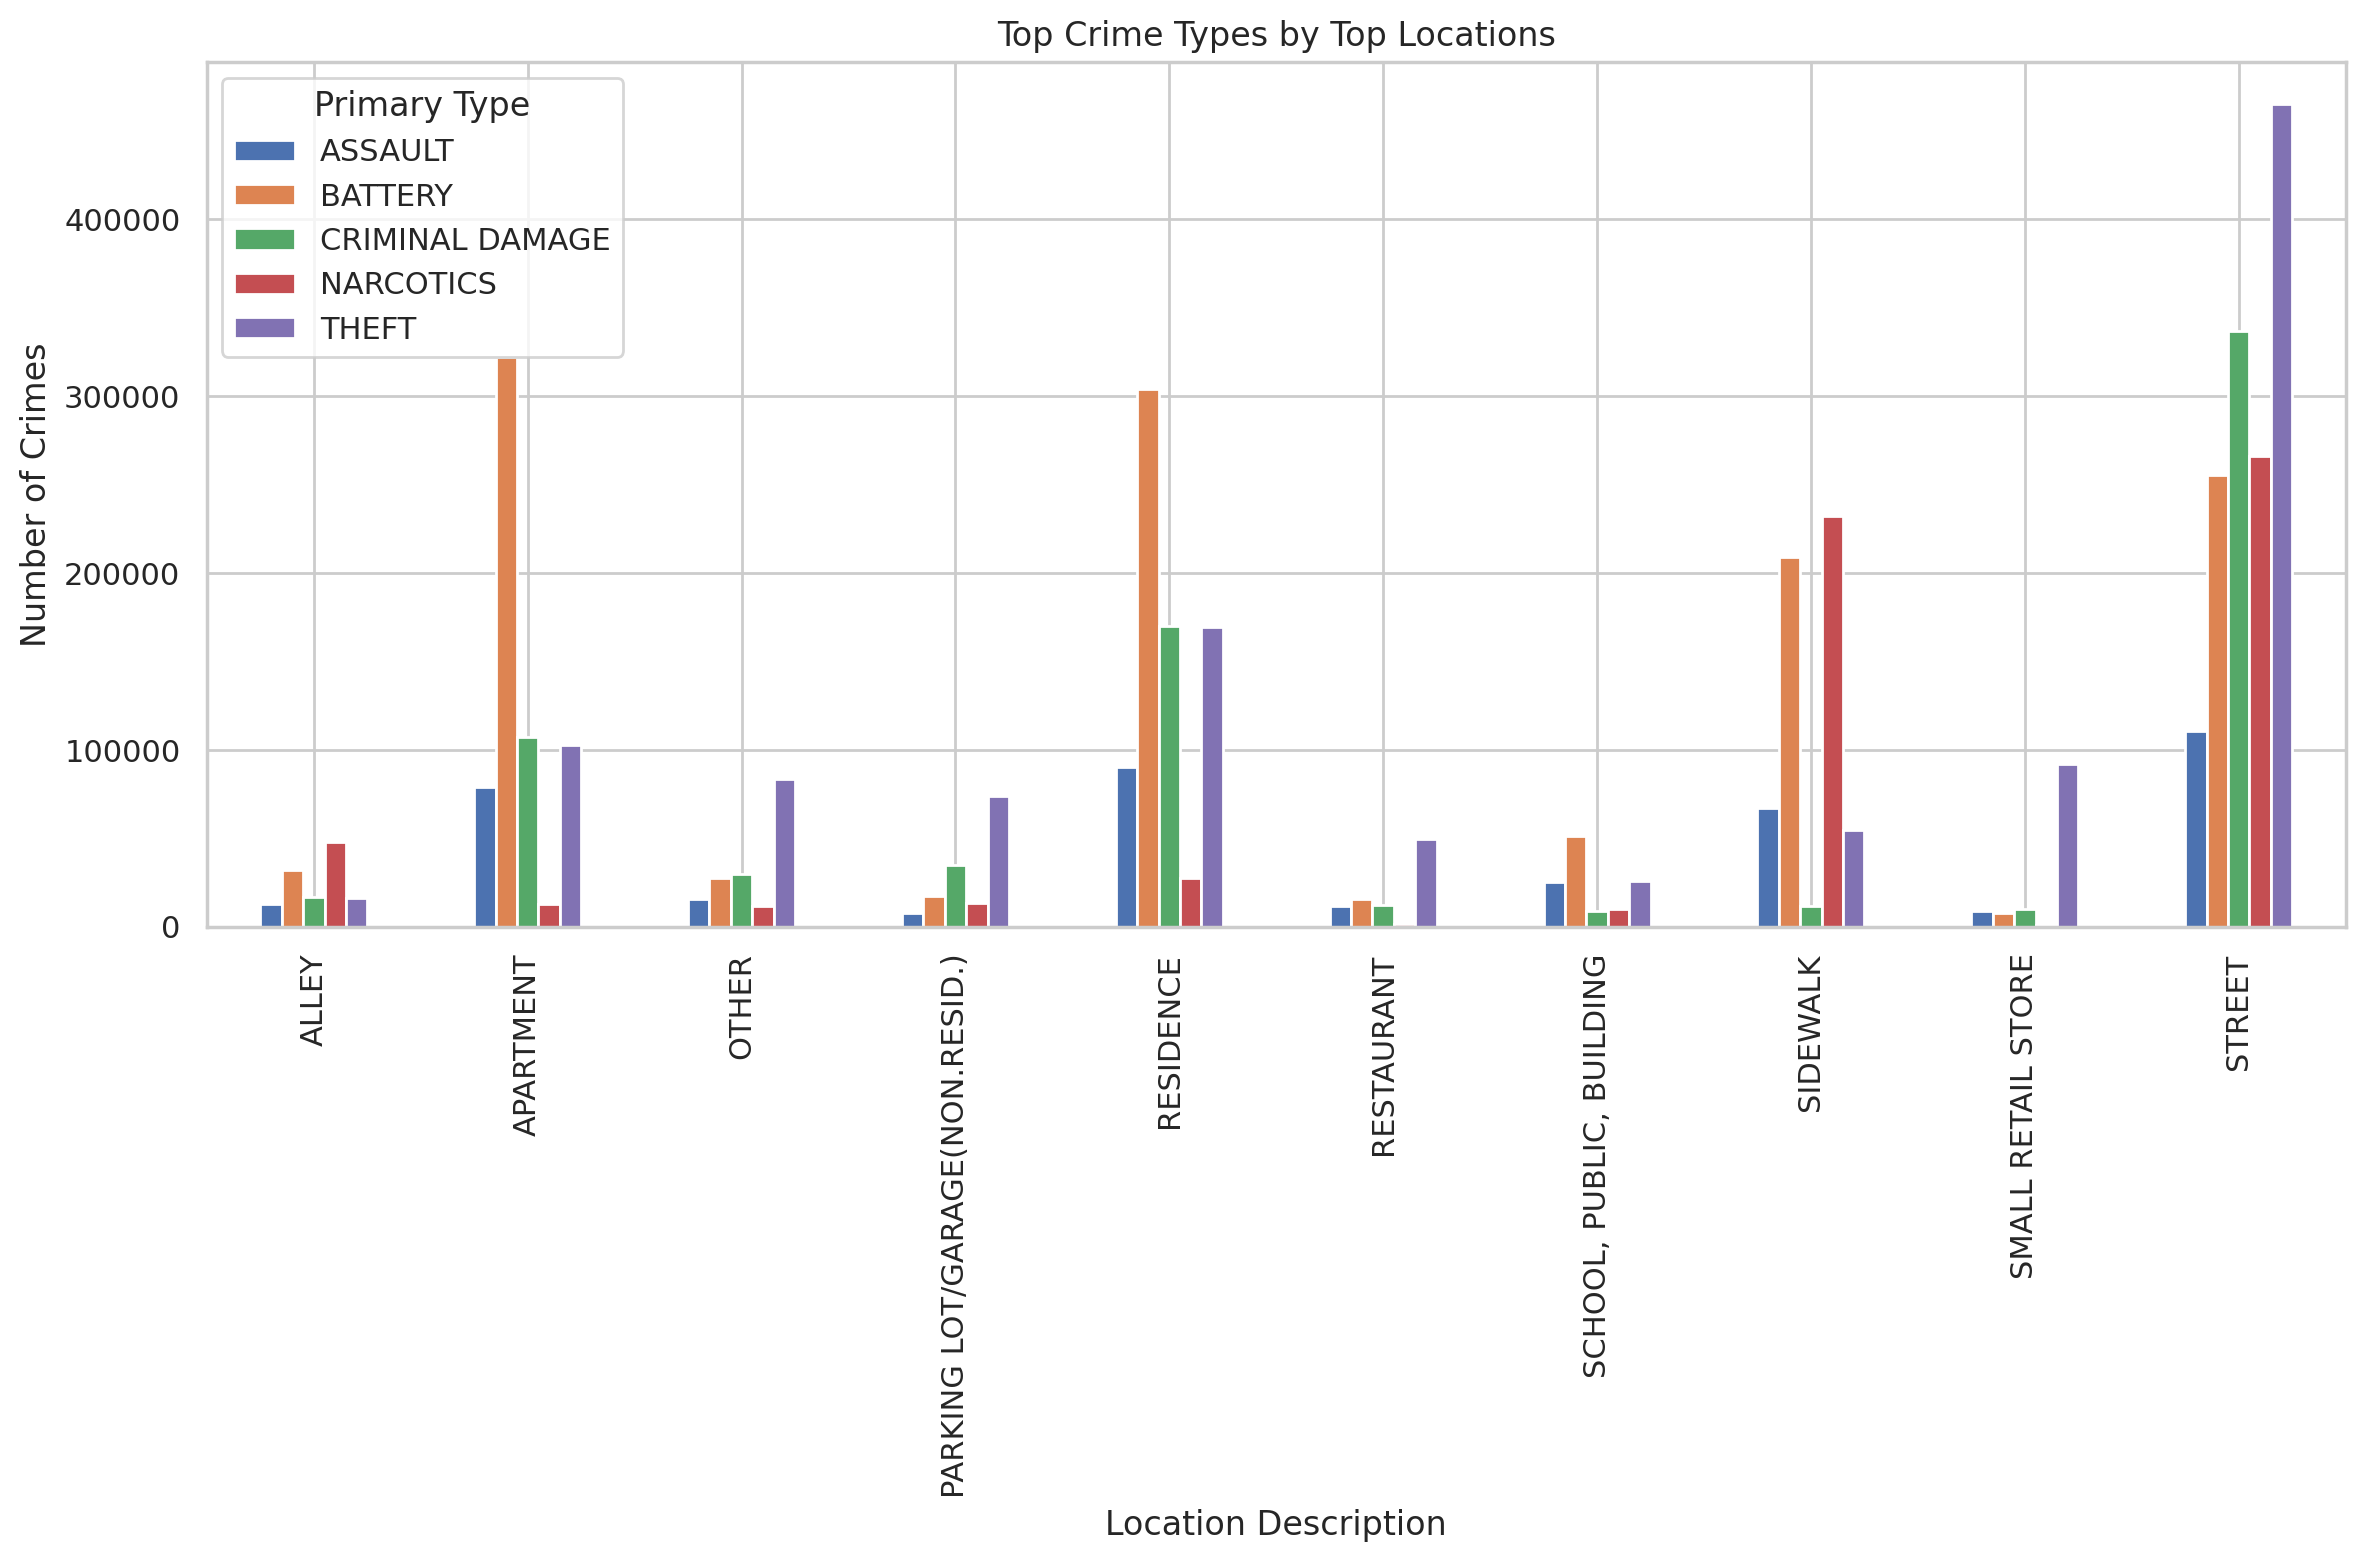

In [ ]:
pivot_table = crime_location_pd.pivot(
    index='Location Description',
    columns='Primary Type',
    values='count'
).fillna(0)

ax = pivot_table.plot(kind='bar', figsize=(12, 8))
plt.title('Top Crime Types by Top Locations')
plt.xlabel('Location Description')
plt.ylabel('Number of Crimes')
plt.legend(title='Primary Type')
plt.tight_layout()
plt.show()

## Hypothesis 5: Patterns of Domestic vs. Non-Domestic Crimes


In [ ]:
domestic_crimes = df_clean.filter(col("Domestic") == True)

domestic_by_hour = domestic_crimes.groupBy("Hour") \
    .count() \
    .orderBy("Hour")

non_domestic_crimes = df_clean.filter(col("Domestic") == False)

non_domestic_by_hour = non_domestic_crimes.groupBy("Hour") \
    .count() \
    .orderBy("Hour")

domestic_pd = domestic_by_hour.toPandas().rename(columns={'count': 'Domestic Crimes'})
non_domestic_pd = non_domestic_by_hour.toPandas().rename(columns={'count': 'Non-Domestic Crimes'})
combined_hourly = domestic_pd.merge(non_domestic_pd, on='Hour')

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Number of Crimes')

Text(0.5, 1.0, 'Domestic vs. Non-Domestic Crimes by Hour')

([<matplotlib.axis.XTick at 0x7a8432443370>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

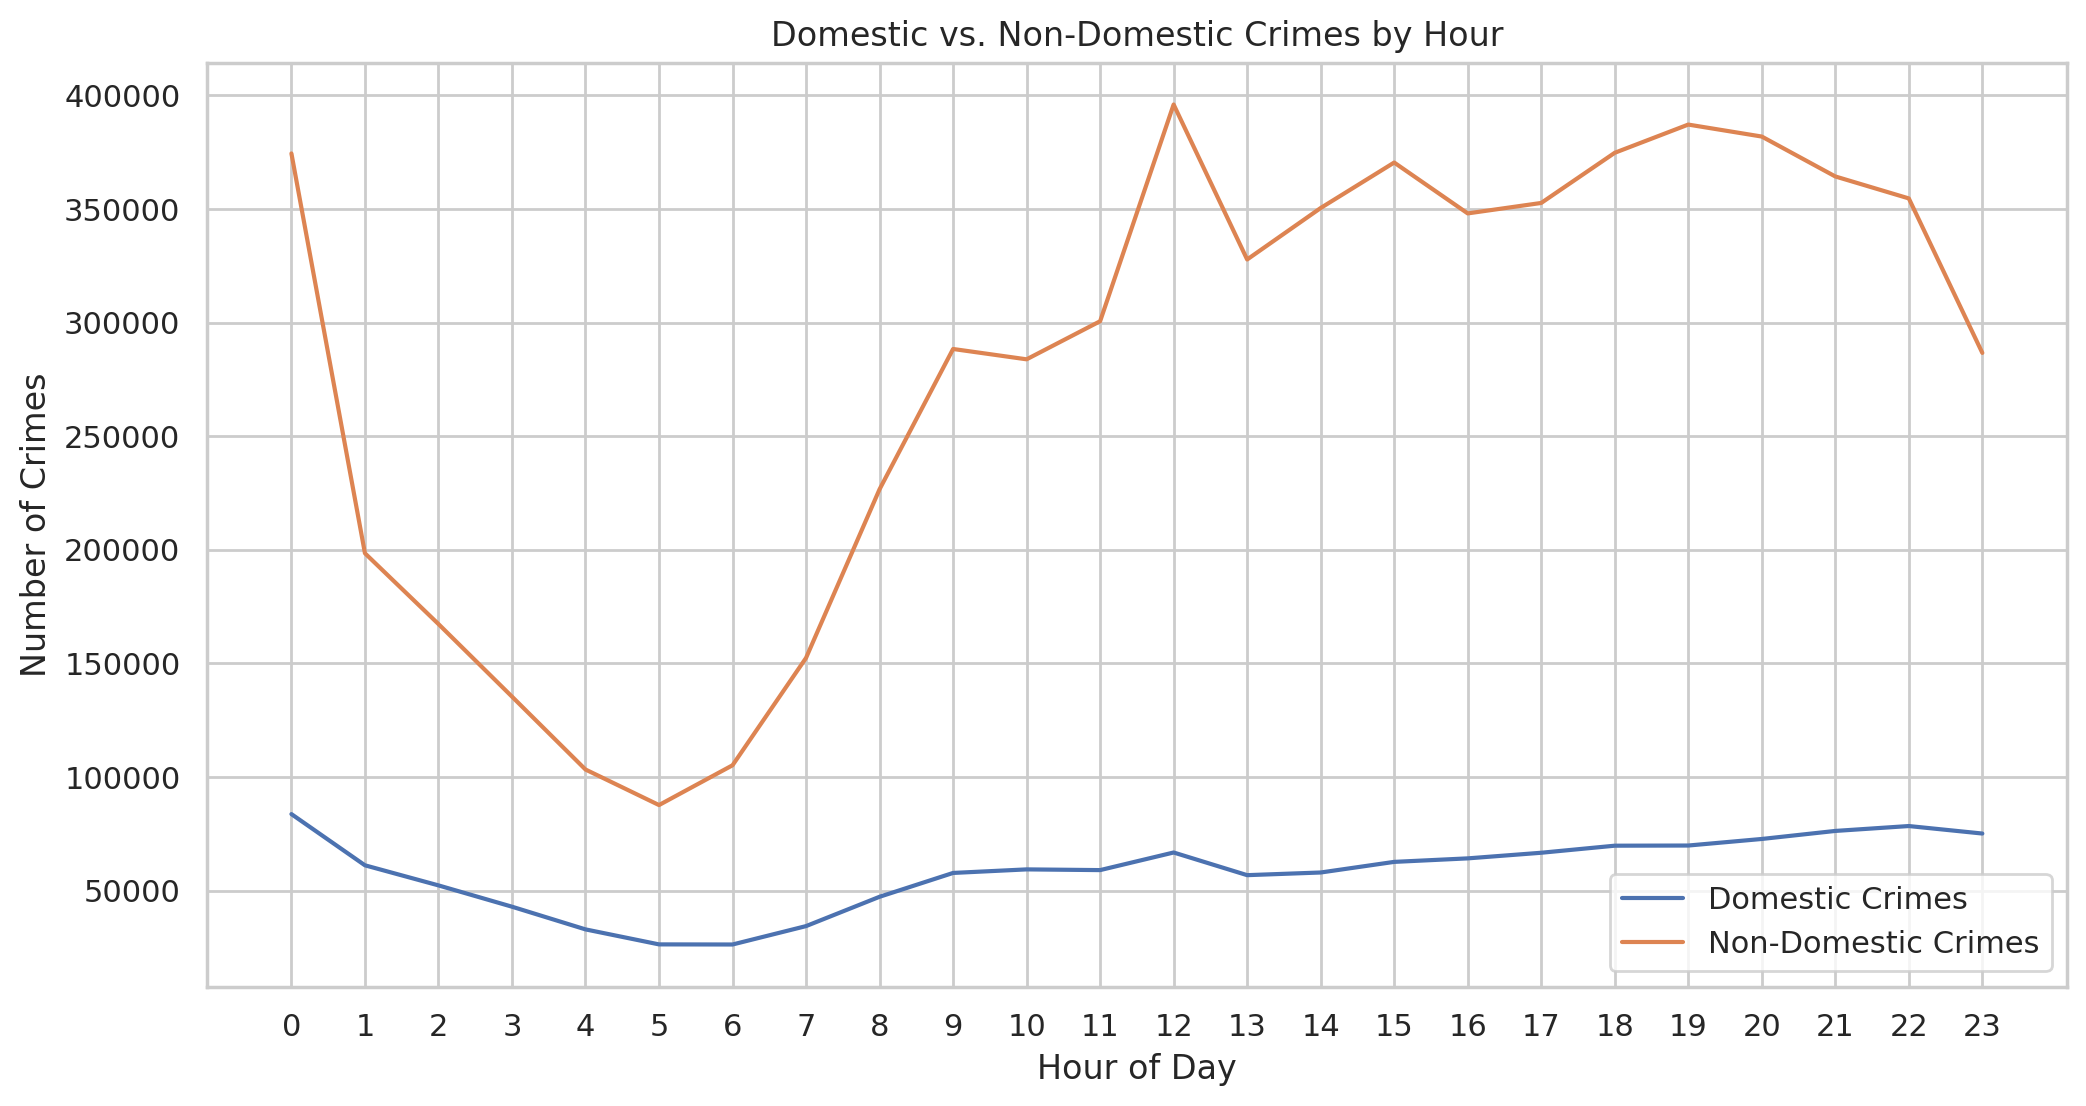

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(combined_hourly['Hour'], combined_hourly['Domestic Crimes'], label='Domestic Crimes')
plt.plot(combined_hourly['Hour'], combined_hourly['Non-Domestic Crimes'], label='Non-Domestic Crimes')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.title('Domestic vs. Non-Domestic Crimes by Hour')
plt.legend()
plt.xticks(range(0, 24))
plt.show()

### 1. Crime Trends Over Years


In [ ]:
crime_by_year = df_clean.groupBy("Year") \
    .count() \
    .orderBy("Year")

year_counts = crime_by_year.toPandas()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Crimes')

Text(0.5, 1.0, 'Crime Trend Over Years')

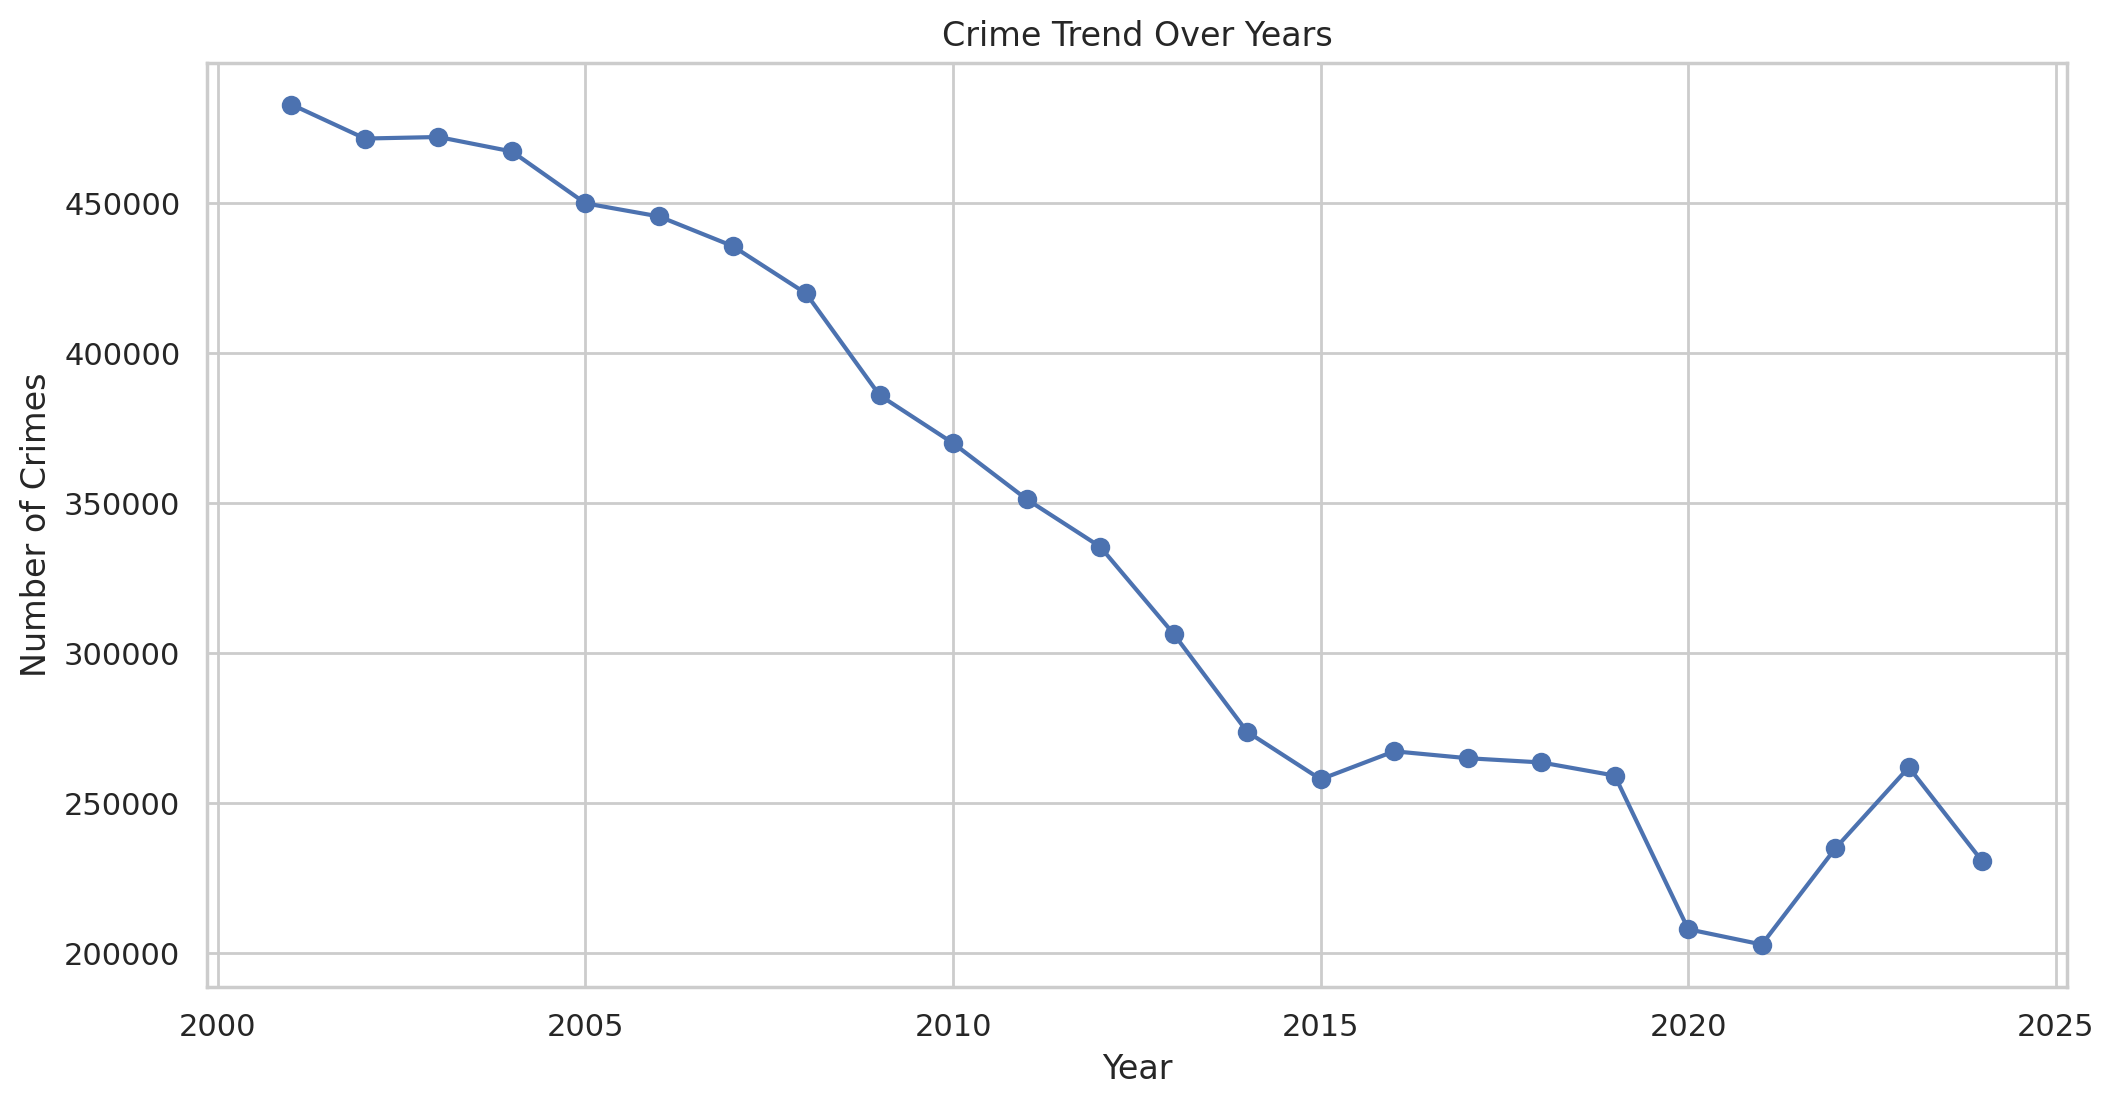

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(year_counts['Year'], year_counts['count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Crime Trend Over Years')
plt.grid(True)
plt.show()

### 2. Arrest Rates Over Years


In [ ]:
arrest_by_year = df_clean.groupBy("Year") \
    .agg(avg(col("Arrest").cast("integer")).alias("Arrest Rate")) \
    .orderBy("Year")

arrest_year_pd = arrest_by_year.toPandas()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Arrest Rate')

Text(0.5, 1.0, 'Arrest Rates Over Years')

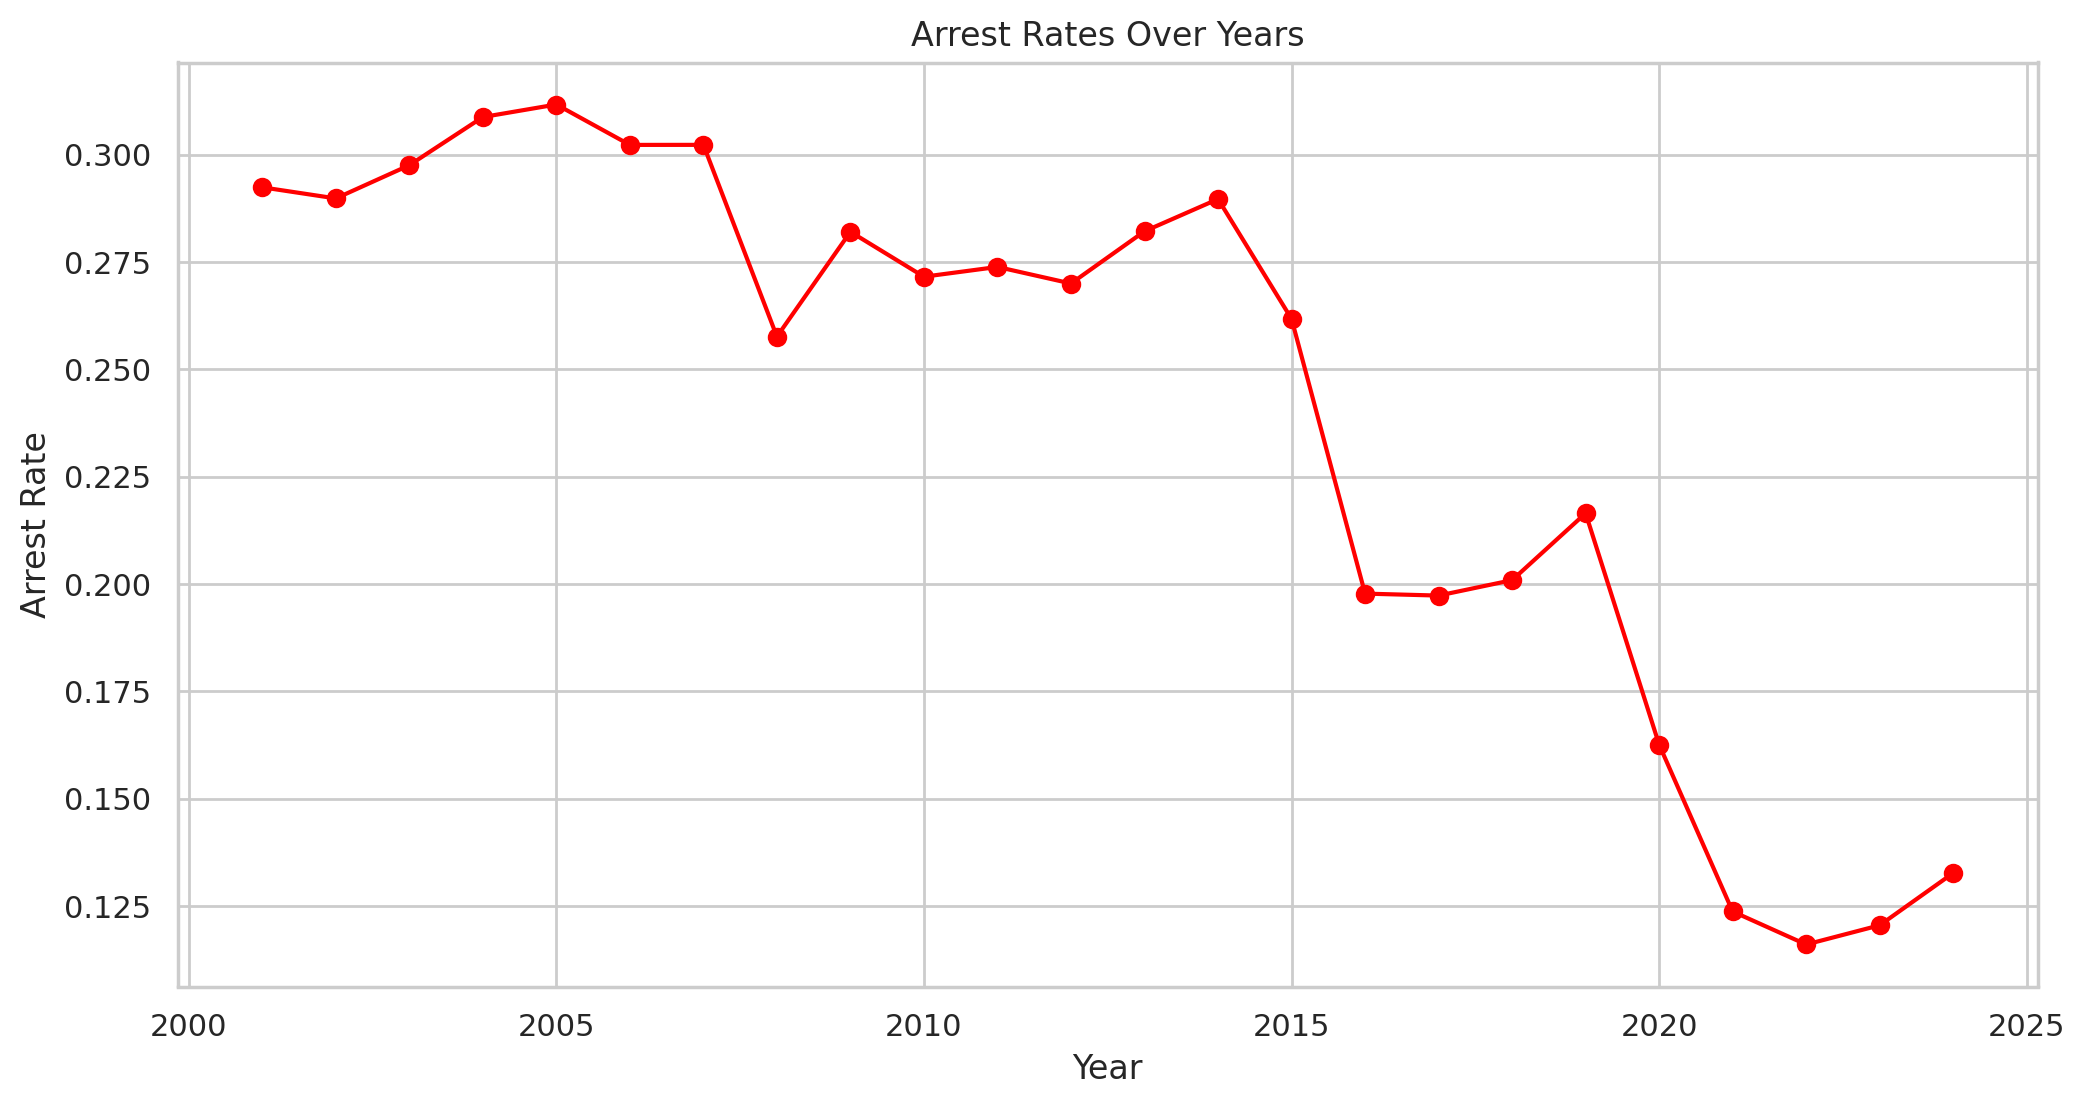

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(arrest_year_pd['Year'], arrest_year_pd['Arrest Rate'], marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rates Over Years')
plt.grid(True)
plt.show()

### 3. Top 10 Community Areas with Highest Crime Rates


In [ ]:
crime_by_area = df_clean.groupBy("Community Area") \
    .count() \
    .orderBy(desc("count")) \
    .limit(10)

area_counts = crime_by_area.toPandas()

<Figure size 1000x600 with 0 Axes>

<ipython-input-42-25a50b529cc6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Community Area', y='count', data=area_counts, palette='magma')


<Axes: xlabel='Community Area', ylabel='count'>

Text(0.5, 0, 'Community Area')

Text(0, 0.5, 'Number of Crimes')

Text(0.5, 1.0, 'Top 10 Community Areas with Highest Crime Rates')

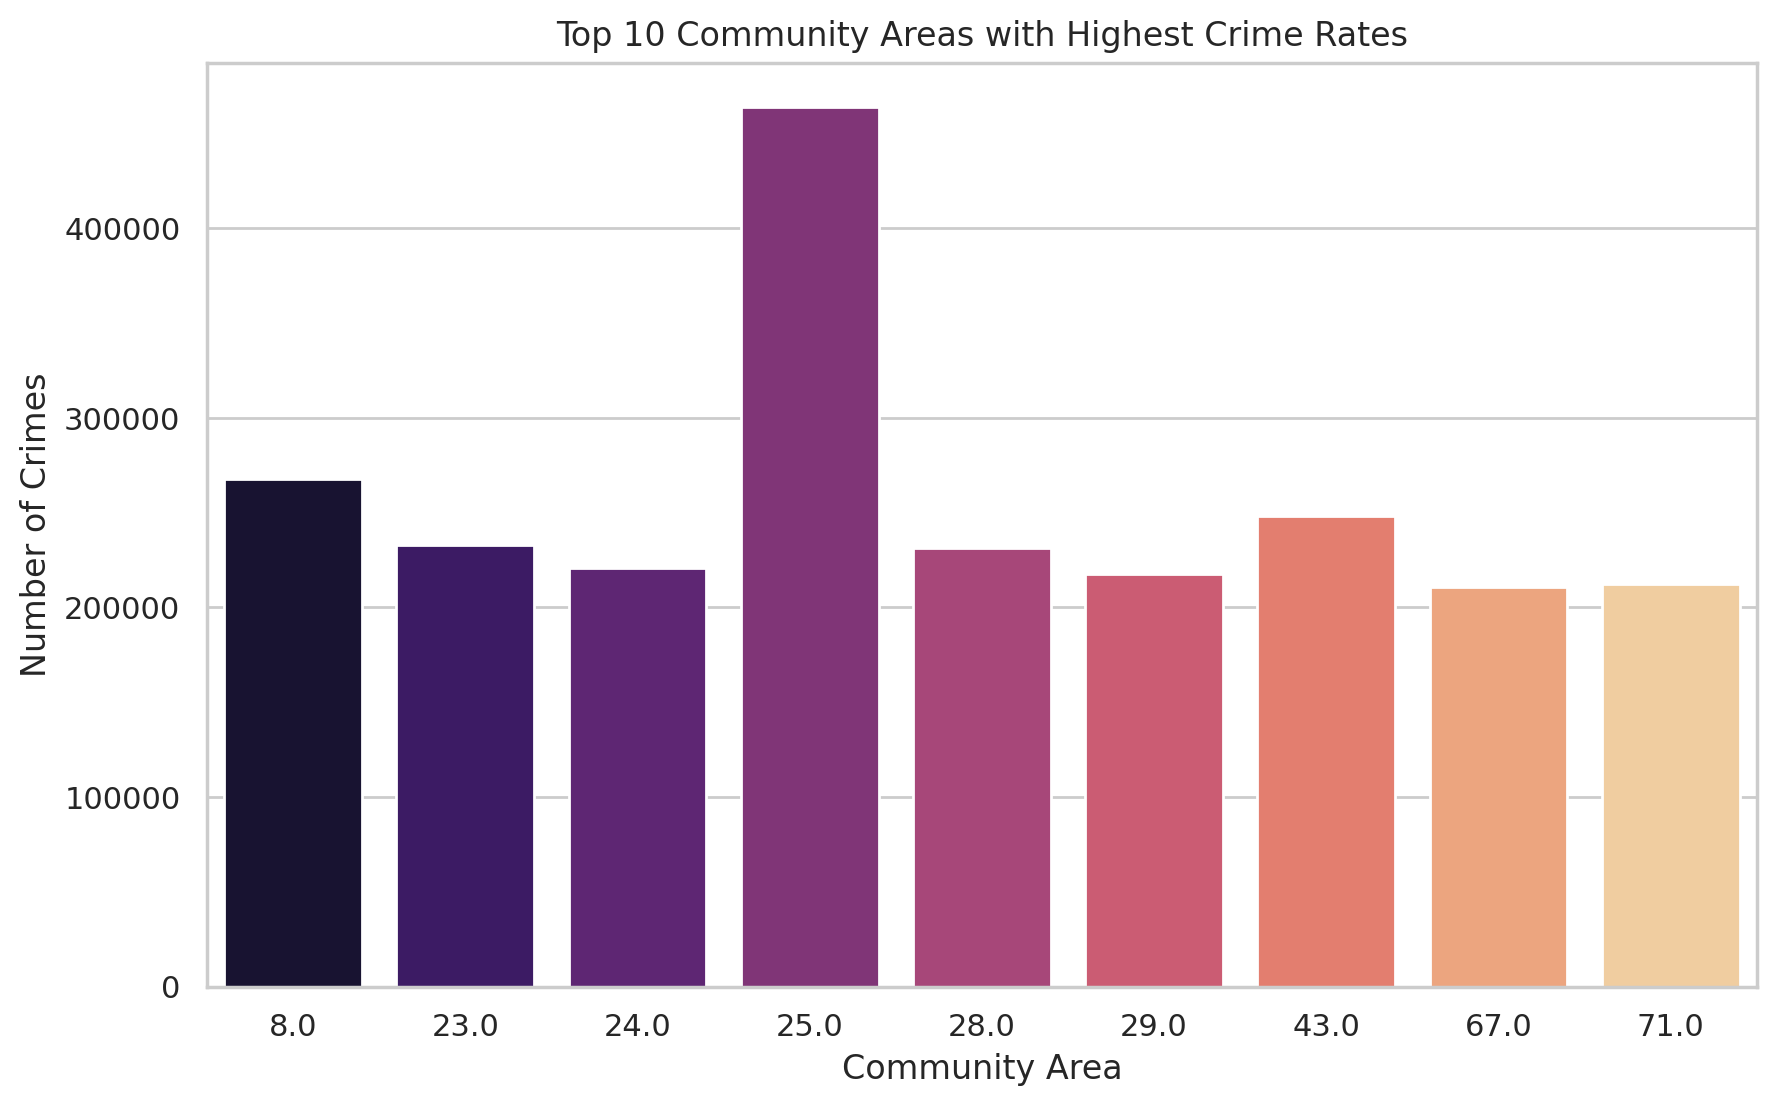

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Community Area', y='count', data=area_counts, palette='magma')
plt.xlabel('Community Area')
plt.ylabel('Number of Crimes')
plt.title('Top 10 Community Areas with Highest Crime Rates')
plt.show()

# Author
*This project was completed by [Ahmed Hmila](https://github.com/ahmedhmila) as part of the Big Data 2 course at EPI Digital School.*
##### Contact : ahmedhmiladev@gmail.com
